# Semantic Textual Similarity

In this project, the **Sentence-Transformer** framework will be used for sentence embeddings (see more at https://www.sbert.net/).

Hence, we begin by importing its library and associated dependencies.

In [ ]:
# Install required packages
!pip install datasets
!pip install pytorch
!pip install transformers
!pip install sentence-transformers

In [ ]:
# Import packages
import numpy as np
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

The corpus used in this project is the **wiki-split** dataset found on *HuggingFace* (see https://huggingface.co/datasets/wiki_split), with a few modifications:

*   The original dataset contains one million English sentences, each split into two sentences that together preserve the original meaning, extracted from Wikipedia Google's WikiSplit dataset, and which was constructed automatically from the publicly available Wikipedia revision history

*   In this project, the column for *sentence 1* was stacked on top of the column for *sentence 2*, thus creating a single list with **two million English sentences**, as shown in the code below

In [ ]:
# Import data
dataset = load_dataset('wiki_split')

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Using custom data configuration default


  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/96.4M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/520k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset wiki_split downloaded and prepared to /root/.cache/huggingface/datasets/wiki_split/default/0.1.0/83151e5f3f5a622601303c2f562ffda5502643e38f3f1fee48999d0030f82b07. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Check data
print(dataset.shape, '\n')
dataset.column_names

{'train': (989944, 3), 'test': (5000, 3), 'validation': (5000, 3)} 



{'test': ['complex_sentence', 'simple_sentence_1', 'simple_sentence_2'],
 'train': ['complex_sentence', 'simple_sentence_1', 'simple_sentence_2'],
 'validation': ['complex_sentence', 'simple_sentence_1', 'simple_sentence_2']}

In [ ]:
# Create corpus of text
corpus = pd.concat(
    [pd.DataFrame(dataset['train']['simple_sentence_1']),
     pd.DataFrame(dataset['train']['simple_sentence_2']),
     pd.DataFrame(dataset['test']['simple_sentence_1']),
     pd.DataFrame(dataset['test']['simple_sentence_2']),
     pd.DataFrame(dataset['validation']['simple_sentence_1']),
     pd.DataFrame(dataset['validation']['simple_sentence_2'])], 
     axis=0, ignore_index=True,
)

print('corpus contains ',corpus.shape[0], ' sentences')

corpus contains  1999888  sentences


In [ ]:
# Check corpus
corpus.head()

,0
0,' '' As she translates from one language to an...
1,' '' BDSM is solely based on consensual activi...
2,' '' Critics criticized the use of the dispute...
3,"' '' Do Re Mi '' ' is a song by Kurt Cobain , ..."
4,"' '' For Robert Price '' docetism '' , togethe..."


## Model Preparation and Embeddings

The pre-trained model chosen for this project was the **sentence-transformers/all-distilroberta-v1** from *HuggingFace*.

This is a **Pytorch** model which maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search (see https://huggingface.co/sentence-transformers/all-distilroberta-v1).

Initially, the *sentence-transformers/all-roberta-large-v1* model was chosen, but during subsequent tests the *DistilRoBERTa* model mentioned above proved to offer similar performance with faster training times (for comparison, the full RoBERTa model uses a 1024 dimensional dense vector space).

***Even with the GPU reources provided by a Google Colab Pro account, processing a corpus of 2 million sentences was the most that could be done for this assignment, as shown in the screenshot below (taken after completing the entire run on this notebook)***

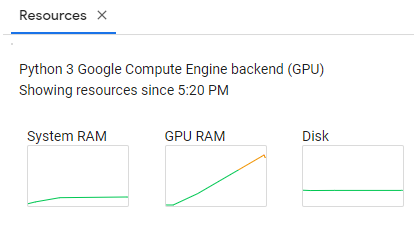

In [ ]:
# Import pre-trained model
model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/653 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Encode corpus to get embeddings
corpus_embeddings = model.encode(corpus[0], convert_to_tensor=True,
                                 show_progress_bar=True)

Batches:   0%|          | 0/62497 [00:00<?, ?it/s]

In [ ]:
# Encode input text
input_txt = 'My cat likes to go out at night'

input_embedding = model.encode(input_txt, convert_to_tensor=True)

## Similarity Rankings

Semantinc similarity between the input text and the two million sentences in the corpus was estimated by calculating **cosine similiarity** using the *pytorch_cos_sim function* available in the *Sentence-Transformers* library. 

In [ ]:
# Compare embeddings and obtain cosine similarity scores
scores = util.pytorch_cos_sim(input_embedding, corpus_embeddings)[0].cpu().numpy()

In [ ]:
# Sort the results in decreasing order and get the first top k
k = 3
top_results = np.argpartition(-scores, range(k))[0:k]
top_results

array([1212520, 1125216, 1896995])

In [ ]:
# Print results
print("Input text:\n", input_txt, "\n")
print("Top", k, "most similar sentences in corpus:")
for idx in top_results:
    print(corpus[0][idx], "(Score: %.4f)" % (scores[idx]))

Input text:
 My cat likes to go out at night 

Top 3 most similar sentences in corpus:
 Cat owners are being advised not to let their cats out at night . (Score: 0.7211)
 He is trapped as a cat during the day , and may freely transform at night . (Score: 0.6269)
 The Cats also possess cat - like night vision . (Score: 0.5950)
